# Test different clustering methods to identify scenarios of high criticality
- PRIM
- K-means
- CART

## Get feature importance
- get dependence measures between features

In [66]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]        
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [6]:
conn = sqlite3.connect(dbFile)
c = conn.cursor()

#c.execute(query)

### print current working directory
import os
print("Current working directory: ", os.getcwd())

### Read and print the tables from dbFile
query = "SELECT * from scenarios"
c.execute(query)
rows = c.fetchall()


### close the connection
conn.close()


NameError: name 'dbFile' is not defined

In [72]:
comb_scenarios = {}

In [70]:
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db' 
#dbFile = 'C:\\Users\\pfoytik\\Documents\\scenarioDiscovery\\lhs_samples\\ladris_scenarios_conv2.db' 


In [71]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            comb_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            ### update the comb_scenarios dictionary with the result but allow duplicates
            ### if the key already exists, create a new key as 12000 + ID
            ### if the key does not exist, create a new list with the value
            for key, value in result.items():
                if key in comb_scenarios:
                    new_key = 12000 + int(key)
                    comb_scenarios[new_key] = value
                else:
                    comb_scenarios[key] = value                

print(len(comb_scenarios))

17892


In [73]:
### join 3 sqlite database files
dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'
dbFiles = [dbFile1, dbFile2, dbFile3]
comb_scenarios = {}
scenCount = 0
for dbFile in dbFiles:
    with ThreadPoolExecutor(max_workers=6) as executor:
        ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
        if 'fleet' in dbFile:
            for result in executor.map(read_fleet_from_db, queries):
                comb_scenarios.update(result)        
        else:
            for result in executor.map(read_ladris_from_db, queries):
                for key, value in result.items():
                    if key in comb_scenarios:
                        new_key = scenCount + int(key)
                        scenCount += 1
                        comb_scenarios[new_key] = value
                    else:
                        comb_scenarios[key] = value 
print(len(comb_scenarios))

12951


### Create Dataframes from the database read
- df_results: a dataframe of the results
- df: a dataframe of the inputs

In [74]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [75]:
experiments = df
### Create outcomes as an array of df_results

### if db file has fleet convert df_results to hours
if 'fleet' in dbFile:
    df_results = df_results/3600

outcomes = list(df_results[0].values)

In [76]:
df.head()

333615  332041  343220  328559  329741  329385  334269  332584  344418  \
0       1       1       1       1       1       1       1       1       1   
1       0       0       0       0       0       0       0       0       0   
2       1       0       0       0       0       0       1       0       0   
3       0       1       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   331224  ...  330399  331209  328168  335242  344419  341317  335083  \
0       1  ...       0       0       0       0       0       0       0   
1       0  ...       0       0       0       0       0       0       0   
2       0  ...       0       0       0       0       0       0       0   
3       0  ...       0       0       0       0       0       0       0   
4       0  ...       0       0       0       0       0       0       0   

   341540  332615  332386  
0       0       0       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0  

[5 rows x 2295 columns]

In [77]:
df_results.head()

0
0  4.183883
1  4.321939
2  4.791880
3  4.189669
4  4.973522

In [78]:
### print the index of the max outcomes
max_index = outcomes.index(max(outcomes))
print(max_index)

7862


In [79]:
### print the row of experiments 7862
print(experiments.iloc[max_index])

333615    0
332041    0
343220    0
328559    0
329741    0
         ..
341317    0
335083    0
341540    0
332615    0
332386    0
Name: 7862, Length: 2295, dtype: int64


In [80]:
### print the the columns that are 1 for max_index
print(experiments.iloc[max_index][experiments.iloc[max_index] == 1])
### get column names of the columns that are 1 for max_index
setOneCols = experiments.columns[experiments.iloc[max_index] == 1]
print(setOneCols)

340786    1
329056    1
336216    1
328862    1
335189    1
         ..
332383    1
330136    1
335090    1
335976    1
344422    1
Name: 7862, Length: 87, dtype: int64
Index([340786, 329056, 336216, 328862, 335189, 343703, 335525, 331077, 343426,
       332206, 332229, 333272, 329821, 331775, 329043, 334420, 335360, 329174,
       334899, 329644, 341324, 336299, 339992, 329802, 332620, 329502, 336276,
       340372, 329091, 328373, 341121, 329670, 331750, 342614, 334931, 338637,
       343088, 333128, 341386, 336224, 331925, 330184, 332329, 342002, 333273,
       344238, 329940, 336066, 341295, 338651, 335712, 344316, 330221, 334722,
       335883, 334250, 343680, 335880, 335451, 334473, 342669, 330512, 336153,
       336067, 332438, 331928, 342678, 332253, 328427, 328156, 342952, 329105,
       342049, 335197, 333582, 339756, 329431, 328932, 343388, 344407, 343312,
       333480, 332383, 330136, 335090, 335976, 344422],
      dtype='int64')


In [81]:
### print descriptive statistics of outcomes
print(df_results.describe())
resultsDesc = df_results.describe()


                  0
count  12951.000000
mean       4.266197
std        1.615423
min        0.000000
25%        3.841514
50%        4.322125
75%        5.032730
max       10.857103


In [105]:
high_results[0]

2        4.791880
4        4.973522
5        4.395238
6        4.521276
8        5.766884
           ...   
12937    5.348989
12943    4.471581
12944    4.892417
12947    4.583354
12948    5.270471
Name: 0, Length: 6475, dtype: float64

In [108]:
quantileDF = high_results[0].quantile([0.1, 0.15, 0.2, .25, 0.3, 0.35, 0.4, .45, .5, 0.55, .65, .75, 0.85, 0.95]) #df_results[0].quantile([0.1, 0.15, 0.2, .25, 0.3, 0.35, 0.4, .45, .5, 0.55, .65, .75, 0.85, 0.95])
print(quantileDF)

### print quantile 0.65 of quantileDF
print(quantileDF[0.65])

0.10    4.422667
0.15    4.475691
0.20    4.530622
0.25    4.607707
0.30    4.682740
0.35    4.773044
0.40    4.871102
0.45    4.947451
0.50    5.032754
0.55    5.127745
0.65    5.303168
0.75    5.566748
0.85    5.853919
0.95    7.405803
Name: 0, dtype: float64
5.303168227777778


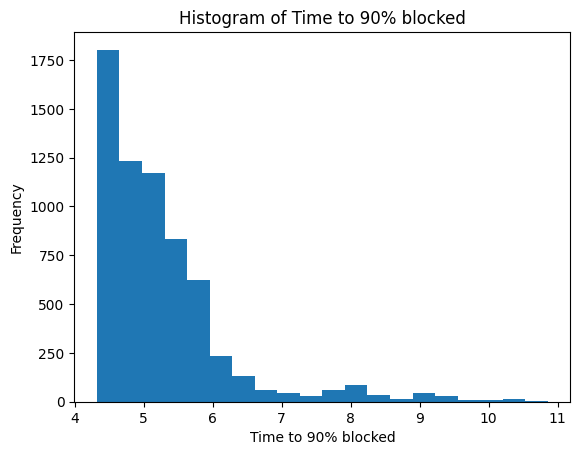

In [109]:
### Plot histogram of df_results[0]
high_results[0].plot(kind='hist', bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()



In [110]:
### resultsDesc print the value for 0 at row index '50%'
print(resultsDesc.loc['50%'][0])
print(quantileDF[0.5])


4.322124944444444
5.032753583333333


In [111]:
print(len(experiments[df_results[0] > quantileDF[0.5]]))
print(len(df_results[df_results[0] > quantileDF[0.5]]))
print(len(df_results))

3237
3237
12951


In [112]:
### establish data sets for high and low outcomes
high_results = df_results[df_results[0] > quantileDF[0.5]]
low_results = df_results[df_results[0] <= quantileDF[0.5]]

### establish data sets for high and low inputs
high_inputs = experiments[df_results[0] > quantileDF[0.5]]
low_inputs = experiments[df_results[0] <= quantileDF[0.5]]

### print the count of high and low outcomes
print(len(high_results))
print(len(low_results))

### print the count of high and low inputs
print(len(high_inputs))
print(len(low_inputs))


3237
9714
3237
9714


# Prim analysis

In [113]:
np_results = df_results[0].to_numpy()

In [114]:
np_results

array([4.18388344, 4.32193894, 4.79188019, ..., 5.27047067, 3.79213639,
       3.78912361])

In [147]:
quantileDF[0.75]

5.566747513888889

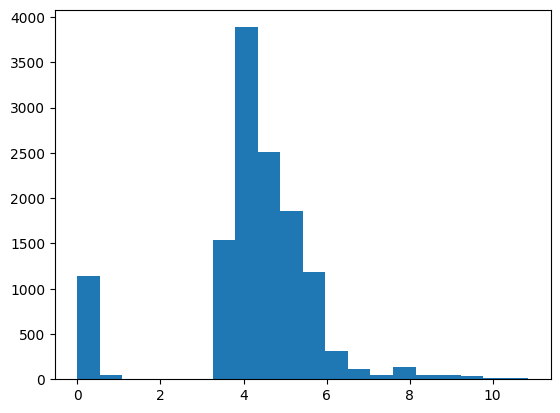

In [115]:
### plot df_results
import matplotlib.pyplot as plt

### plot histogram of df_results
plt.hist(df_results[0], bins=20)
plt.show()

In [116]:
import prim as p_rim

In [117]:
result_limits = {}

# High and Low Limits Data

In [149]:
### establish data sets for high and low outcomes
high_results = df_results[df_results[0] > quantileDF[0.65]]
low_results = df_results[df_results[0] <= quantileDF[0.65]]

### establish data sets for high and low inputs
high_inputs = experiments[df_results[0] > quantileDF[0.65]]
low_inputs = experiments[df_results[0] <= quantileDF[0.65]]

### print the count of high and low outcomes
print(len(high_results))
print(len(low_results))

### print the count of high and low inputs
print(len(high_inputs))
print(len(low_inputs))

2266
10685
2266
10685


In [150]:
### Print the length of high and low results and high and low inputs
print(len(high_results))
print(len(low_results))
print(len(high_inputs))
print(len(low_inputs))

2266
10685
2266
10685


# PRIM Analysis

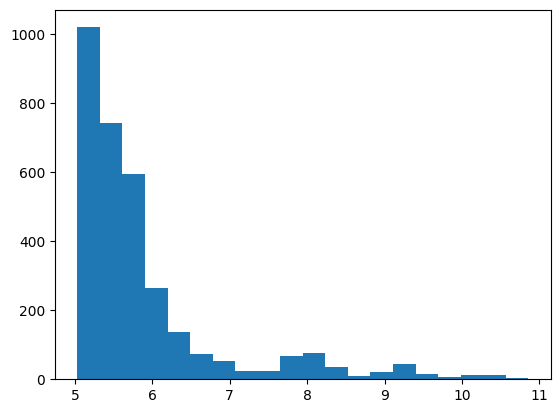

In [120]:
### show histogram of high results
plt.hist(high_results[0], bins=20)
plt.show()


In [121]:
high_results

0
8      5.766884
9      5.371179
19     6.004234
21     5.186744
24     5.156590
...         ...
12922  5.737165
12925  5.333897
12930  5.223800
12937  5.348989
12948  5.270471

[3237 rows x 1 columns]

In [122]:
### sample 2000 rows from high_results
high_results.sample(n=2000, random_state=1)

0
9010   5.837977
6242   7.472914
11423  5.250966
9627   6.395662
9849   5.462457
...         ...
5089   5.181590
7160   5.815789
649    5.554054
3637   5.484486
5311   5.495042

[2000 rows x 1 columns]

In [151]:
### select random 1000 samples of high and low results
import random

### get 1000 indexes of high and low results
#high_indexes = random.sample(range(0, len(high_results)), 1000)
#low_indexes = random.sample(range(0, len(low_results)), 1000)

samp_high_results = []
samp_high_results.append(high_results.sample(n=1000))
samp_high_results.append(high_results.sample(n=1000))
samp_high_results.append(high_results.sample(n=1000))
samp_high_results.append(high_results.sample(n=1000))

samp_low_results = []
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))



In [152]:
samp_high_results[0]

0
9041   5.780283
9608   6.171245
9665   7.984923
9019   5.785027
6606   5.960550
...         ...
8095   5.582170
10229  5.323522
8354   8.048913
3121   5.601294
6245   5.475996

[1000 rows x 1 columns]

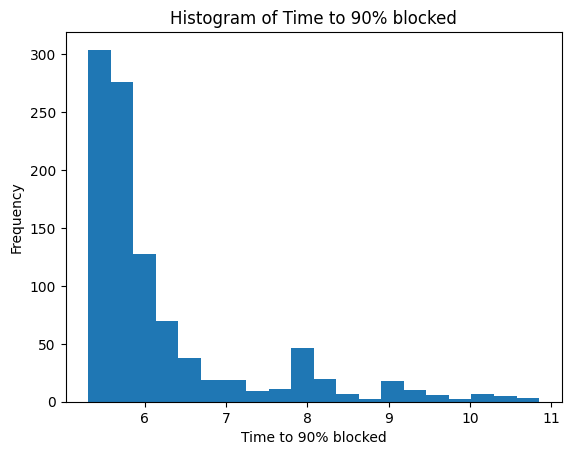

In [153]:
## Print df_results for index values of samp_high_results[0]
### print histogram of df_results.iloc[samp_high_results[0]]
plt.hist(samp_high_results[0][0], bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()

In [143]:
# Create a boolean mask approach
mask = high_inputs.index.isin(samp_high_results[0].index)
newHIGH_df = high_inputs[mask]

In [144]:
newHIGH_df

333615  332041  343220  328559  329741  329385  334269  332584  344418  \
9           0       0       0       1       0       0       0       0       0   
21          0       0       0       0       0       0       0       0       0   
30          0       0       0       0       0       0       0       0       0   
42          0       0       0       0       1       0       0       0       0   
47          0       0       0       1       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
12855       0       0       0       0       0       0       0       0       0   
12868       0       0       0       0       0       0       0       0       0   
12874       0       0       0       0       0       0       0       0       0   
12886       0       0       0       0       0       0       0       0       0   
12916       0       0       0       0       0       0       0       0       0   

       331224  ...  330399  331209  328168  335242  344419  341317  335083  \
9           0  ...       0       0       0       0       0       0       0   
21          0  ...       0       0       0       0       0       0       0   
30          0  ...       0       0       0       0       0       0       0   
42          0  ...       0       0       0       0       0       0       0   
47          0  ...       0       0       0       0       0       0       0   
...       ...  ...     ...     ...     ...     ...     ...     ...     ...   
12855       0  ...       0       0       0       0       0       0       0   
12868       0  ...       0       0       0       0       0       0       0   
12874       0  ...       0       0       0       0       0       0       0   
12886       0  ...       0       0       0       0       0       0       0   
12916       0  ...       0       0       0       0       0       0       0   

       341540  332615  332386  
9           0       0       0  
21          0       0       0  
30          0       0       0  
42          0       0       0  
47          0       0       0  
...       ...     ...     ...  
12855       0       0       0  
12868       0       0       0  
12874       0       0       0  
12886       0       0       0  
12916       0       0       0  

[1000 rows x 2295 columns]

In [145]:
print(quantileDF[0.75])

quantileDF

5.566747513888889


0.10    4.422667
0.15    4.475691
0.20    4.530622
0.25    4.607707
0.30    4.682740
0.35    4.773044
0.40    4.871102
0.45    4.947451
0.50    5.032754
0.55    5.127745
0.65    5.303168
0.75    5.566748
0.85    5.853919
0.95    7.405803
Name: 0, dtype: float64

In [130]:
print(len(high_inputs), len(high_results[0]))


3237 3237


In [36]:
newHIGH_df

330221  334722  329174  344238  328156  336153  341386  342952  329091  \
0          1       1       1       1       1       1       1       1       1   
3          1       0       0       0       0       1       1       0       0   
7          0       0       0       0       1       1       0       0       1   
8          0       1       0       1       1       1       0       1       0   
9          1       0       0       0       1       0       0       1       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1986       1       1       1       1       1       0       0       1       1   
1992       1       1       1       1       1       0       0       0       0   
1993       1       1       0       0       1       0       0       0       1   
1996       1       1       1       0       0       1       1       0       0   
1997       1       1       1       0       1       0       1       0       1   

      329644  ...  332329  338651  334250  335451  342669  341295  329502  \
0          1  ...       0       0       0       0       0       0       0   
3          1  ...       0       1       0       0       0       1       1   
7          1  ...       0       1       1       1       1       1       1   
8          1  ...       0       1       1       1       1       0       1   
9          1  ...       0       0       0       0       0       0       0   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1986       1  ...       1       0       0       1       0       0       1   
1992       0  ...       1       1       0       1       0       1       0   
1993       0  ...       0       1       0       1       0       1       0   
1996       1  ...       0       0       0       1       1       0       1   
1997       1  ...       1       1       0       0       0       1       0   

      341121  333480  343388  
0          0       0       0  
3          1       0       1  
7          1       0       1  
8          0       0       0  
9          1       0       1  
...      ...     ...     ...  
1986       0       0       0  
1992       1       1       0  
1993       0       0       0  
1996       0       0       0  
1997       1       0       0  

[1000 rows x 28 columns]

In [131]:
samp_high_results[0]

0
9566   5.265986
3857   5.067285
3406   5.797533
12868  5.100530
9655   5.118349
...         ...
12090  5.468853
1013   5.831124
2743   5.034754
530    5.087747
7632   5.544947

[2000 rows x 1 columns]

In [38]:
print(len(high_results), len(high_inputs))

1000 1000


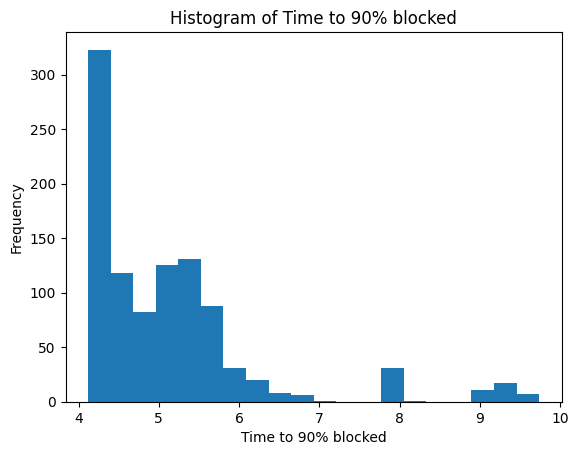

In [39]:
### Plot histogram of high_results
plt.hist(high_results[0], bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()

In [40]:
high_inputs

330221  334722  329174  344238  328156  336153  341386  342952  329091  \
0          1       1       1       1       1       1       1       1       1   
3          1       0       0       0       0       1       1       0       0   
7          0       0       0       0       1       1       0       0       1   
8          0       1       0       1       1       1       0       1       0   
9          1       0       0       0       1       0       0       1       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1986       1       1       1       1       1       0       0       1       1   
1992       1       1       1       1       1       0       0       0       0   
1993       1       1       0       0       1       0       0       0       1   
1996       1       1       1       0       0       1       1       0       0   
1997       1       1       1       0       1       0       1       0       1   

      329644  ...  332329  338651  334250  335451  342669  341295  329502  \
0          1  ...       0       0       0       0       0       0       0   
3          1  ...       0       1       0       0       0       1       1   
7          1  ...       0       1       1       1       1       1       1   
8          1  ...       0       1       1       1       1       0       1   
9          1  ...       0       0       0       0       0       0       0   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1986       1  ...       1       0       0       1       0       0       1   
1992       0  ...       1       1       0       1       0       1       0   
1993       0  ...       0       1       0       1       0       1       0   
1996       1  ...       0       0       0       1       1       0       1   
1997       1  ...       1       1       0       0       0       1       0   

      341121  333480  343388  
0          0       0       0  
3          1       0       1  
7          1       0       1  
8          0       0       0  
9          1       0       1  
...      ...     ...     ...  
1986       0       0       0  
1992       1       1       0  
1993       0       0       0  
1996       0       0       0  
1997       1       0       0  

[1000 rows x 28 columns]

In [41]:
high_results

0
0     5.249842
3     4.652006
7     4.392114
8     4.814068
9     4.125840
...        ...
1986  5.348989
1992  4.471581
1993  4.892417
1996  4.583354
1997  5.270471

[1000 rows x 1 columns]

In [42]:
quantileDF[0.75]

4.910395

In [43]:
### print high_results[0] > quantileDF[0.75]
print(high_results[high_results[0] > quantileDF[0.75]])

             0
0     5.249842
10    5.247785
15    5.243494
16    5.682941
19    5.438655
...        ...
1971  5.737165
1974  5.333897
1979  5.223800
1986  5.348989
1997  5.270471

[500 rows x 1 columns]


# utilize prim on samp_high_results
- high inputs comes from the mask of samp_high_results[i]

### Create a boolean mask approach
- mask = high_inputs.index.isin(samp_high_results[0].index)
- newHIGH_df = high_inputs[mask]

In [137]:
prim_alg = p_rim.Prim(newHIGH_df, samp_high_results[0][0], threshold=quantileDF[0.95], threshold_type='>')
box = prim_alg.find_box()
print(len(box.limits))

0


In [45]:
allBoxes = prim_alg.find_all()

In [46]:
box.limits

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


min  max  qp values
330221  1.0  1.0        NaN
334722  1.0  1.0        NaN
329091  1.0  1.0        NaN
329644  1.0  1.0        NaN
335525  1.0  1.0        NaN

In [47]:
allBoxes[0].limits.to_dict()

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


{'min': {'330221': 1.0, '334722': 1.0, '329644': 1.0, '334420': 1.0},
 'max': {'330221': 1.0, '334722': 1.0, '329644': 1.0, '334420': 1.0},
 'qp values': {'330221': nan, '334722': nan, '329644': nan, '334420': nan}}

In [51]:
allBoxes[0].stats


{'coverage': 0.164,
 'density': 0.9761904761904762,
 'mean': 0.9761904761904762,
 'res dim': 4,
 'mass': 0.084}

In [52]:
### get the dictionary for each allBoxes and store the results in allBoxIndexes
allBoxIndexes = {}
### get allBoxes.limits.to_dict() for each box
for i in range(len(allBoxes)):    
    allBoxIndexes[i] = allBoxes[i].limits.to_dict()
    #print(allBoxIndexes[i])
    print(allBoxes[i].stats)

    



{'coverage': 0.164, 'density': 0.9761904761904762, 'mean': 0.9761904761904762, 'res dim': 4, 'mass': 0.084}
{'coverage': 0.132, 'density': 0.9166666666666666, 'mean': 0.9166666666666666, 'res dim': 4, 'mass': 0.072}
{'coverage': 0.18, 'density': 1.0, 'mean': 1.0, 'res dim': 4, 'mass': 0.09}
{'coverage': 0.148, 'density': 0.7789473684210526, 'mean': 0.7789473684210526, 'res dim': 3, 'mass': 0.095}
{'coverage': 0.088, 'density': 0.6567164179104478, 'mean': 0.6567164179104478, 'res dim': 4, 'mass': 0.067}
{'coverage': 0.074, 'density': 0.6981132075471698, 'mean': 0.6981132075471698, 'res dim': 3, 'mass': 0.053}
{'coverage': 0.054, 'density': 0.2621359223300971, 'mean': 0.2621359223300971, 'res dim': 2, 'mass': 0.103}
{'coverage': 0.01, 'density': 0.06578947368421052, 'mean': 0.06578947368421052, 'res dim': 1, 'mass': 0.076}
{'coverage': 0.002, 'density': 0.02, 'mean': 0.02, 'res dim': 2, 'mass': 0.05}
{'coverage': 0.0, 'density': 0.0, 'mean': 0.0, 'res dim': 0, 'mass': 0.236}


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scal

In [53]:
allBoxIndexes

{0: {'min': {'330221': 1.0, '334722': 1.0, '329644': 1.0, '334420': 1.0},
  'max': {'330221': 1.0, '334722': 1.0, '329644': 1.0, '334420': 1.0},
  'qp values': {'330221': nan, '334722': nan, '329644': nan, '334420': nan}},
 1: {'min': {'330221': 1.0, '334722': 1.0, '329091': 1.0, '330184': 1.0},
  'max': {'330221': 1.0, '334722': 1.0, '329091': 1.0, '330184': 1.0},
  'qp values': {'330221': nan, '334722': nan, '329091': nan, '330184': nan}},
 2: {'min': {'330221': 1.0, '329644': 1.0, '329821': 1.0, '330512': 1.0},
  'max': {'330221': 1.0, '329644': 1.0, '329821': 1.0, '330512': 1.0},
  'qp values': {'330221': nan, '329644': nan, '329821': nan, '330512': nan}},
 3: {'min': {'330221': 1.0, '334722': 1.0, '334420': 1.0},
  'max': {'330221': 1.0, '334722': 1.0, '334420': 1.0},
  'qp values': {'330221': nan, '334722': nan, '334420': nan}},
 4: {'min': {'334722': 0.0, '329644': 1.0, '329821': 0.0, '330512': 1.0},
  'max': {'334722': 0.0, '329644': 1.0, '329821': 0.0, '330512': 1.0},
  'qp va

In [54]:
allBoxIndexes[1]

{'min': {'330221': 1.0, '334722': 1.0, '329091': 1.0, '330184': 1.0},
 'max': {'330221': 1.0, '334722': 1.0, '329091': 1.0, '330184': 1.0},
 'qp values': {'330221': nan, '334722': nan, '329091': nan, '330184': nan}}

In [55]:
### get rows of df[329091] that are equal to 0 and df[331775] that are equal to 1
mask = (df[329091] == 0) & (df[331775] == 1)
results_ofKeys8 = df[mask]


In [56]:
funnyScenar = df_results[mask]

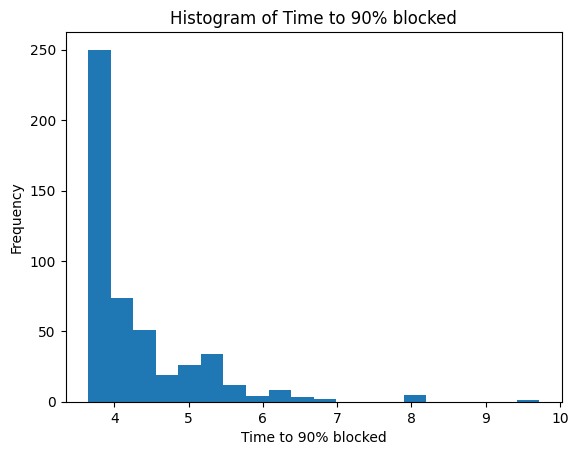

In [57]:
###Plot histogram of funnyScenar
plt.hist(funnyScenar[0], bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()

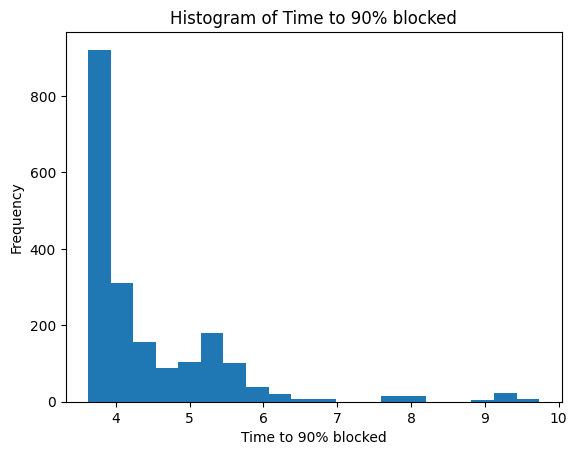

In [58]:
###Plot histograma of df_results
plt.hist(df_results[0], bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()

[330221, 329644, 329821, 330512]


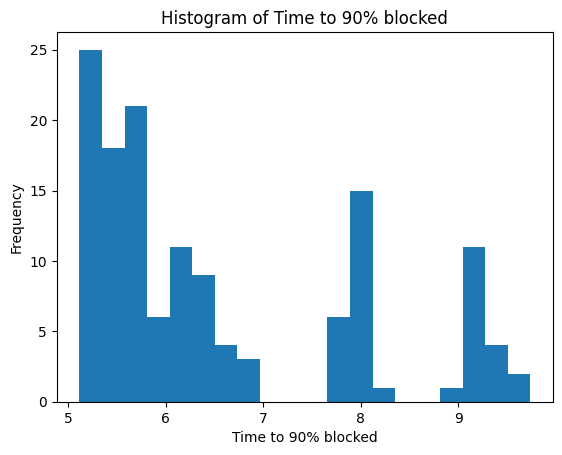

In [59]:
box0_keys = list(allBoxIndexes[2]['min'].keys())
### set keys in box0_keys to integer
for i in range(len(box0_keys)):
    box0_keys[i] = int(box0_keys[i])
### print box0_keys
print(box0_keys)

#box0_keys = [329091, 331775]


### get all df rows where columns in box0_keys are 1
box0_rows = df[box0_keys].sum(axis=1) == len(box0_keys)
box0_rows = box0_rows[box0_rows == True]
box0_rows = box0_rows.index
box0_rows = list(box0_rows)

### get all df_results where index in box0_rows
box0_results = df_results[df_results.index.isin(box0_rows)]
### plot histogram of box0_results
plt.hist(box0_results[0], bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()

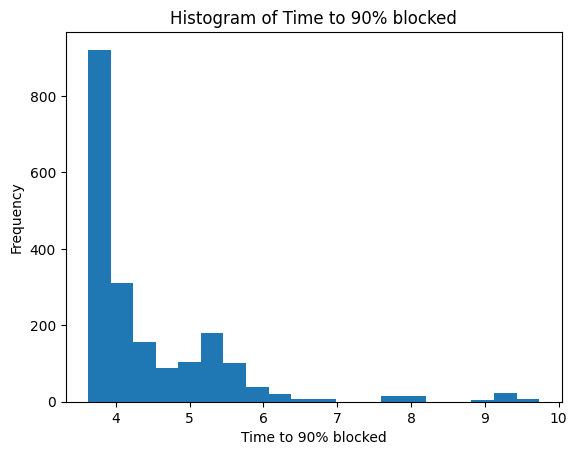

In [60]:
### Plot histogram of df_results
plt.hist(df_results[0], bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()

In [190]:
def is_in_box(row, box_min, box_max):
    for feat, min_val in box_min.items():
        if row.get(int(feat), 0) < min_val:
            return False
    for feat, max_val in box_max.items():
        if row.get(int(feat), 0) > max_val:
            return False
    return True

def generate_box_features(X: pd.DataFrame, box_data: dict) -> pd.DataFrame:
    box_features = pd.DataFrame(index=X.index)

    for box_id, box_limits in box_data.items():
        box_min = box_limits.get('min', {})
        box_max = box_limits.get('max', {})

        # For each row, determine if it satisfies the box conditions
        box_features[f'box_{box_id}'] = X.apply(lambda row: is_in_box(row, box_min, box_max), axis=1).astype(int)

    return box_features


In [62]:
X_augmented = pd.concat([df, generate_box_features(df, allBoxIndexes)], axis=1)
X_augmented.head()

330221  334722  329174  344238  328156  336153  341386  342952  329091  \
0       1       1       1       1       1       1       1       1       1   
1       0       0       1       0       1       1       0       1       0   
2       0       0       1       1       1       1       1       0       0   
3       1       0       0       0       0       1       1       0       0   
4       0       0       1       0       1       0       0       1       0   

   329644  ...  box_0  box_1  box_2  box_3  box_4  box_5  box_6  box_7  box_8  \
0       1  ...      0      1      0      0      0      1      0      1      0   
1       1  ...      0      0      0      0      1      0      0      0      1   
2       1  ...      0      0      0      0      0      0      0      0      0   
3       1  ...      0      0      0      0      1      0      1      0      0   
4       0  ...      0      0      0      0      0      0      1      0      1   

   box_9  
0      1  
1      1  
2      1  
3      1  
4      1  

[5 rows x 38 columns]

In [63]:
### drop 'qp values' from allBoxIndexes
for i in range(len(allBoxIndexes)):
    allBoxIndexes[i].pop('qp values', None)

print(allBoxIndexes[0])
### output allBoxIndexes to json file called ladris_conv2_scenarioDiscovery.json
import json
with open('ladris_conv2_scenarioDiscovery.json', 'w') as f:
    json.dump(allBoxIndexes, f)

{'min': {'330221': 1.0, '334722': 1.0, '329644': 1.0, '334420': 1.0}, 'max': {'330221': 1.0, '334722': 1.0, '329644': 1.0, '334420': 1.0}}


In [64]:
### for each dictionary in allBoxIndexes get the min and max values for each key
### allBoxIndexesMinMax[key] = [min, max]
### get the min and max values for each key in allBoxIndexes
allBoxIndexesMinMax = {}
for i in allBoxIndexes:
    #print(allBoxIndexes[i])
    for j in allBoxIndexes[i]["min"]:
        print(j, allBoxIndexes[i]["min"][j], allBoxIndexes[i]["max"][j])
        ### if j not in allBoxIndexesMinMax: then create it else append to it
        if j not in allBoxIndexesMinMax:
            allBoxIndexesMinMax[j] = [allBoxIndexes[i]["min"][j], allBoxIndexes[i]["max"][j]]
        else:
            allBoxIndexesMinMax[j].append([allBoxIndexes[i]["min"][j], allBoxIndexes[i]["max"][j]])




330221 1.0 1.0
334722 1.0 1.0
329644 1.0 1.0
334420 1.0 1.0
330221 1.0 1.0
334722 1.0 1.0
329091 1.0 1.0
330184 1.0 1.0
330221 1.0 1.0
329644 1.0 1.0
329821 1.0 1.0
330512 1.0 1.0
330221 1.0 1.0
334722 1.0 1.0
334420 1.0 1.0
334722 0.0 0.0
329644 1.0 1.0
329821 0.0 0.0
330512 1.0 1.0
334722 1.0 1.0
329091 1.0 1.0
334420 0.0 0.0
330512 1.0 1.0
329502 1.0 1.0
334722 1.0 1.0
329091 0.0 0.0
331775 1.0 1.0


In [65]:
allBoxIndexesMinMax

{'330221': [1.0, 1.0, [1.0, 1.0], [1.0, 1.0], [1.0, 1.0]],
 '334722': [1.0,
  1.0,
  [1.0, 1.0],
  [1.0, 1.0],
  [0.0, 0.0],
  [1.0, 1.0],
  [1.0, 1.0]],
 '329644': [1.0, 1.0, [1.0, 1.0], [1.0, 1.0]],
 '334420': [1.0, 1.0, [1.0, 1.0], [0.0, 0.0]],
 '329091': [1.0, 1.0, [1.0, 1.0], [0.0, 0.0]],
 '330184': [1.0, 1.0],
 '329821': [1.0, 1.0, [0.0, 0.0]],
 '330512': [1.0, 1.0, [1.0, 1.0], [1.0, 1.0]],
 '329502': [1.0, 1.0],
 '331775': [1.0, 1.0]}

# TODO: create output that includes scenario discovery info such as road index values and open or closed

In [119]:
allBoxIndexesMinMax.keys()

dict_keys(['330221', '334722', '329644', '334420', '329091', '330184', '329821', '330512', '329502', '331775'])

In [349]:
result_limits['high_limits'] = box.limits

In [ ]:
prim_alg = p_rim.Prim(low_inputs, low_results[0], threshold=resultsDesc.loc['25%'][0], threshold_type='<')
box = prim_alg.find_box()
print(len(box.limits))

0


In [353]:
box.limits

Empty DataFrame
Columns: [min, max, qp values]
Index: []

In [354]:
result_limits['low_limits'] = box.limits

In [164]:
quantileDF

0.10    4.422667
0.15    4.475691
0.20    4.530622
0.25    4.607707
0.30    4.682740
0.35    4.773044
0.40    4.871102
0.45    4.947451
0.50    5.032754
0.55    5.127745
0.65    5.303168
0.75    5.566748
0.85    5.853919
0.95    7.405803
Name: 0, dtype: float64

In [162]:
### get the mean of samp_high_results[0][0]
mean_high = samp_high_results[0][0].mean()
print(mean_high)

6.191657730055557


In [157]:
quantileDF[0.75]

5.566747513888889

In [181]:
### run prim on all samp_high_results
allBoxes = []
for i in range(len(samp_high_results)):
    ### get the index values of samp_high_results[i]
    mask = high_inputs.index.isin(samp_high_results[i].index)    
    prim_alg = p_rim.Prim(high_inputs[mask], samp_high_results[i][0], threshold=quantileDF[0.75], threshold_type=">")
    box = prim_alg.find_all()
    print(len(box))
    allBoxes.append(box)    
    result_limits['samp_high_results_' + str(i)] = box
          

#prim_alg = p_rim.Prim(high_inputs, high_results[0], threshold=22000.0, threshold_type=">")
print(result_limits.keys())

2
2
2
2
dict_keys(['samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3'])


In [189]:
### Pickle the result_limits dictionary
import pickle
with open('result_limits_ladris.pickle', 'wb') as f:
    pickle.dump(result_limits, f)




In [187]:
result_limits['samp_high_results_3'][0].limits

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


min  max  qp values
343319  0.0  0.0        NaN
343311  0.0  0.0        NaN
332423  0.0  0.0        NaN
330160  0.0  0.0        NaN
329533  0.0  0.0        NaN
329456  0.0  0.0        NaN
331203  0.0  0.0        NaN
332401  0.0  0.0        NaN
333546  0.0  0.0        NaN
335108  0.0  0.0        NaN
332395  0.0  0.0        NaN
343334  0.0  0.0        NaN

In [177]:
mask = high_inputs.index.isin(samp_high_results[3].index)
prim_alg = p_rim.Prim(high_inputs[mask], samp_high_results[3][0], threshold=quantileDF[0.75], threshold_type=">")
#result_limits['samp_high_results_3']

In [178]:
allBoxes = prim_alg.find_all()
print(len(allBoxes))

2


In [180]:
allBoxes[0].limits

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


min  max  qp values
343319  0.0  0.0        NaN
343311  0.0  0.0        NaN
332423  0.0  0.0        NaN
330160  0.0  0.0        NaN
329533  0.0  0.0        NaN
329456  0.0  0.0        NaN
331203  0.0  0.0        NaN
332401  0.0  0.0        NaN
333546  0.0  0.0        NaN
335108  0.0  0.0        NaN
332395  0.0  0.0        NaN
343334  0.0  0.0        NaN

{'min': {}, 'max': {}, 'qp values': {}}

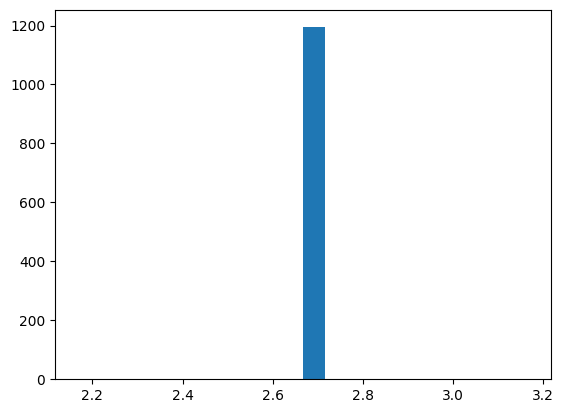

In [358]:
### plot histogram of low results
plt.hist(low_results[0], bins=20)
plt.show()

In [359]:
quantileDF[0.45]

2.6666666666666665

In [ ]:
### run prim on all samp_low_results
for i in range(len(samp_low_results)):
    prim_alg = p_rim.Prim(low_inputs.iloc[samp_low_results[i]], low_results.iloc[samp_low_results[i]][0], threshold=quantileDF[0.25], threshold_type="<")
    box = prim_alg.find_box()
    print(len(box.limits))
    result_limits['samp_low_results_' + str(i)] = box.limits
          

#prim_alg = p_rim.Prim(high_inputs, high_results[0], threshold=22000.0, threshold_type=">")
print(result_limits.keys())

0
0
0
0
dict_keys(['high_limits', 'low_limits', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3'])


In [362]:
### drop key values 'samp_low_limits 0', 'samp_low_limits)0', 'samp_low_limits_0' from result_limits
print(len(result_limits.keys()))
result_limits.keys()



10


dict_keys(['high_limits', 'low_limits', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3'])

In [363]:
result_limits['samp_low_results_1']

Empty DataFrame
Columns: [min, max, qp values]
Index: []

# KMeans tests of the inputs finding input paterns

In [364]:
### cluster the results
from sklearn.cluster import KMeans

### kmeans cluster the columns of high_inputs
kmeans = KMeans(n_clusters=6, n_init=20, random_state=21).fit(high_inputs.iloc[samp_high_results[0]].T)

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())


1    3
0    2
2    2
5    1
3    1
4    1
Name: count, dtype: int64


In [365]:
### print the labels for cluster 2
print(high_inputs.columns[kmeans.labels_ == 2])


Index(['1173061709', '10116970483'], dtype='object')


In [366]:
result_limits['high_kmeans'] = kmeans

In [367]:
### kmeans cluster the columns of high_inputs
kmeans = KMeans(n_clusters=4, random_state=21).fit(low_inputs.T)

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())

3    5
1    2
2    2
0    1
Name: count, dtype: int64


In [368]:
result_limits['low_kmeans'] = kmeans

In [369]:
result_limits['low_kmeans']

KMeans(n_clusters=4, random_state=21)

In [370]:
### get the index's of results for each cluster
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

idx0 = []
idx1 = []
idx2 = []
idx3 = []

for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        cluster0.append(df_resultsMAX[0].iloc[i])
        idx0.append(i)
    elif kmeans.labels_[i] == 1:
        cluster1.append(df_resultsMAX[0].iloc[i])
        idx1.append(i)
    elif kmeans.labels_[i] == 2:
        cluster2.append(df_resultsMAX[0].iloc[i])
        idx2.append(i)
    elif kmeans.labels_[i] == 3:
        cluster3.append(df_resultsMAX[0].iloc[i])
        idx3.append(i)

len(cluster0)

NameError: name 'df_resultsMAX' is not defined

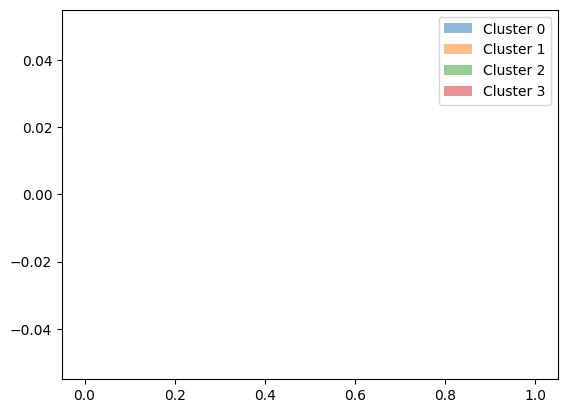

In [371]:
### plot a histogram all the clusters
plt.hist(cluster0, bins=10, alpha=0.5, label='Cluster 0')
plt.hist(cluster1, bins=10, alpha=0.5, label='Cluster 1')
plt.hist(cluster2, bins=10, alpha=0.5, label='Cluster 2')
plt.hist(cluster3, bins=10, alpha=0.5, label='Cluster 3')
plt.legend(loc='upper right')
plt.show()

In [372]:
### print colum names of df.iloc[idx0] that have values greater than 0
print(len(df.iloc[idx0].columns[(df.iloc[idx0] > 0).any()]))
print(len(df.iloc[idx1].columns[(df.iloc[idx1] > 0).any()]))
print(len(df.iloc[idx2].columns[(df.iloc[idx2] > 0).any()]))
print(len(df.iloc[idx3].columns[(df.iloc[idx3] > 0).any()]))



0
0
0
0


In [373]:
### for each df.iloc[idx0] print the sum of all columns sorted from highest to lowest
print(df.iloc[idx0].sum().sort_values(ascending=False))

### get the top 10 columns of df.iloc[idx0] that have the highest sum
maxSegs0 = df.iloc[idx0].sum().sort_values(ascending=False).head(200)
maxSegs1 = df.iloc[idx1].sum().sort_values(ascending=False).head(200)
maxSegs2 = df.iloc[idx2].sum().sort_values(ascending=False).head(200)
maxSegs3 = df.iloc[idx3].sum().sort_values(ascending=False).head(200)


10105537445    0.0
1173061709     0.0
949301691      0.0
10091170129    0.0
10116945306    0.0
10112051514    0.0
10116970483    0.0
949536370      0.0
10091169783    0.0
711443713      0.0
dtype: float64


In [374]:
overlaps = []
### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx1]
overlap = maxSegs0.index.intersection(maxSegs1.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx2]
overlap = maxSegs0.index.intersection(maxSegs2.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx3]
overlap = maxSegs0.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx1] and df.iloc[idx2]
overlap = maxSegs1.index.intersection(maxSegs2.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx1] and df.iloc[idx3]
overlap = maxSegs1.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx2] and df.iloc[idx3]
overlap = maxSegs2.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)


Index(['10105537445', '1173061709', '949301691', '10091170129', '10116945306',
       '10112051514', '10116970483', '949536370', '10091169783', '711443713'],
      dtype='object')
Index(['10105537445', '1173061709', '949301691', '10091170129', '10116945306',
       '10112051514', '10116970483', '949536370', '10091169783', '711443713'],
      dtype='object')
Index(['10105537445', '1173061709', '949301691', '10091170129', '10116945306',
       '10112051514', '10116970483', '949536370', '10091169783', '711443713'],
      dtype='object')
Index(['10105537445', '1173061709', '949301691', '10091170129', '10116945306',
       '10112051514', '10116970483', '949536370', '10091169783', '711443713'],
      dtype='object')
Index(['10105537445', '1173061709', '949301691', '10091170129', '10116945306',
       '10112051514', '10116970483', '949536370', '10091169783', '711443713'],
      dtype='object')
Index(['10105537445', '1173061709', '949301691', '10091170129', '10116945306',
       '10112051514',

In [375]:
for o in overlaps:
    for i in o:
        if i in primSegments:
            print(i)

NameError: name 'primSegments' is not defined

Text(0, 0.5, 'Frequency')

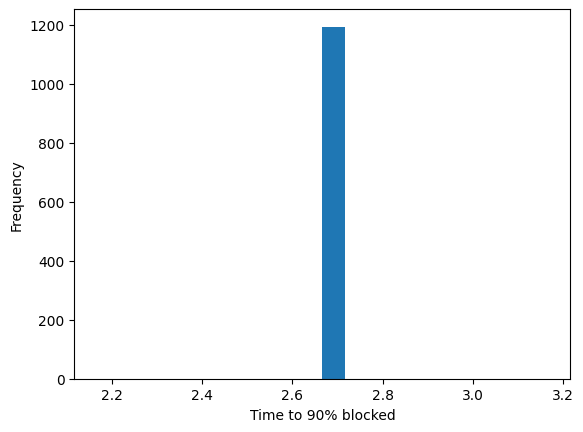

In [376]:
low_results[0].plot(kind='hist', bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')

# CART Tests (Focusing on features of 0 not 1)
- Hierarchical result of features split to form combinations associated with outputs of interest, order matters!
- low coverage values indicate boxes of rare specific behaviors
- high coverage values indicate boxes of general themes
- res dim indicates the number of features associated with the variation

In [377]:
#low_results[0]

### create a numpy array of df_results less than 3.99
np_results = low_results[0].to_numpy()
### modify np_results to be an array of true or false values 
np_results = np_results < resultsDesc.loc['50%'][0]
### print the length of np_results
print(len(np_results), len(low_inputs))

1194 1194


In [378]:
### perform CART on the high inputs and high results
import ema_workbench.analysis.cart as CART

ca = CART.CART(low_inputs, np_results, mode='REGRESSION')
ca.build_tree()

In [379]:
c_df = ca.boxes_to_dataframe()
print(len(c_df))
print(c_df)

ValueError: can only convert an array of size 1 to a Python scalar

In [386]:
#### Get the index of the features of the tree

fi = ca.clf.tree_.compute_feature_importances()
### print the index of the top 10 features
colIdx = fi.argsort()[-len(c_df):][::-1]
print(colIdx)

[9 8 7 6 5 4 3 2 1 0]


In [387]:
### print the column names of low_inputs that are in colIdx
print(low_inputs.columns[colIdx])

Index(['711443713', '10091169783', '949536370', '10116970483', '10112051514',
       '10116945306', '10091170129', '949301691', '1173061709', '10105537445'],
      dtype='object')


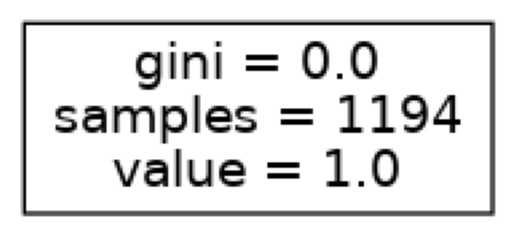

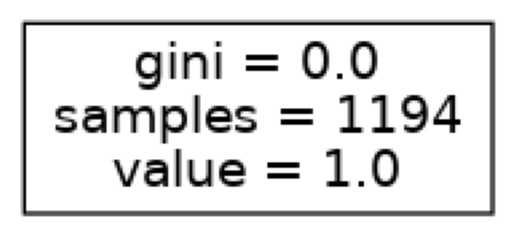

In [388]:
ca.show_tree()

In [389]:
boxesdf = ca.boxes_to_dataframe()

ValueError: can only convert an array of size 1 to a Python scalar

In [390]:
len(ca.boxes)

ValueError: can only convert an array of size 1 to a Python scalar

In [391]:
for i in range(1, len(ca.boxes)):
    print(len(boxesdf['box {}'.format(i)]))

ValueError: can only convert an array of size 1 to a Python scalar

In [392]:
result_limits['low_CART'] = ca

In [393]:
low_results.iloc[samp_low_results[0]][0].to_numpy() < resultsDesc.loc['25%'][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [394]:
### Run CART on samp_low_results
for i in range(len(samp_low_results)):
    slr = low_results.iloc[samp_low_results[i]][0].to_numpy() < resultsDesc.loc['50%'][0]
    ca = CART.CART(low_inputs.iloc[samp_low_results[i]], slr)
    ca.build_tree()
    print(ca.stats_to_dataframe())
    print(ca.boxes_to_dataframe())
    result_limits['samp_low_CART_' + str(i)] = ca

ValueError: can only convert an array of size 1 to a Python scalar

In [395]:
slr = high_results[0].to_numpy() > resultsDesc.loc['75%'][0]
ca = CART.CART(high_inputs, slr)
ca.build_tree()


In [396]:
print(ca.stats_to_dataframe())

print(ca.boxes_to_dataframe())

boxesdf = ca.boxes_to_dataframe()
boxesdf.head()

        coverage   density  res dim      mass
box 1   0.003322  0.017241        2  0.071960
box 2   0.000000  0.000000        2  0.142680
box 3   0.000000  0.000000        4  0.064516
box 4   0.006645  0.050000        5  0.049628
box 5   0.142857  0.651515        5  0.081886
box 6   0.000000  0.000000        3  0.075682
box 7   0.000000  0.000000        4  0.110422
box 8   0.066445  0.377358        5  0.065757
box 9   0.122924  0.880952        5  0.052109
box 10  0.116279  0.700000        5  0.062035
box 11  0.093023  0.622222        5  0.055831
box 12  0.448505  1.000000        4  0.167494
            box 1      box 2      box 3      box 4      box 5       ... box 8  \
              min  max   min  max   min  max   min  max   min  max  ...   min   
10116945306   0.0  0.5   0.0  0.5   0.5  1.0   0.5  1.0   0.5  1.0  ...   0.5   
10091170129   0.0  0.5   0.5  1.0   0.0  0.5   0.0  0.5   0.0  0.5  ...   0.5   
10105537445   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0  ...   0.0 

box 1      box 2      box 3      box 4      box 5       ... box 8  \
              min  max   min  max   min  max   min  max   min  max  ...   min   
10116945306   0.0  0.5   0.0  0.5   0.5  1.0   0.5  1.0   0.5  1.0  ...   0.5   
10091170129   0.0  0.5   0.5  1.0   0.0  0.5   0.0  0.5   0.0  0.5  ...   0.5   
10105537445   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0  ...   0.0   
949536370     0.0  1.0   0.0  1.0   0.0  0.5   0.0  0.5   0.0  0.5  ...   0.0   
711443713     0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0  ...   0.0   

                 box 9      box 10      box 11      box 12       
             max   min  max    min  max    min  max    min  max  
10116945306  1.0   0.5  1.0    0.5  1.0    0.5  1.0    0.5  1.0  
10091170129  1.0   0.5  1.0    0.5  1.0    0.5  1.0    0.5  1.0  
10105537445  0.5   0.5  1.0    0.0  1.0    0.0  1.0    0.0  1.0  
949536370    1.0   0.0  1.0    0.0  1.0    0.0  1.0    0.0  1.0  
711443713    1.0   0.0  1.0    0.0  0.5    0.0  0.5    0.5  1.0  

[5 rows x 24 columns]

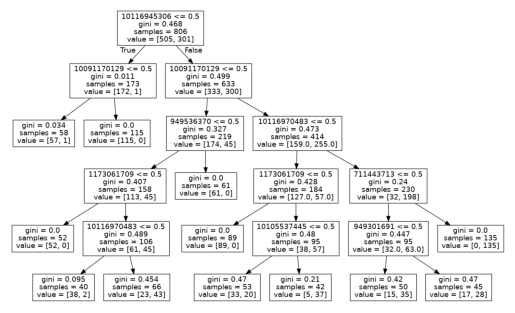

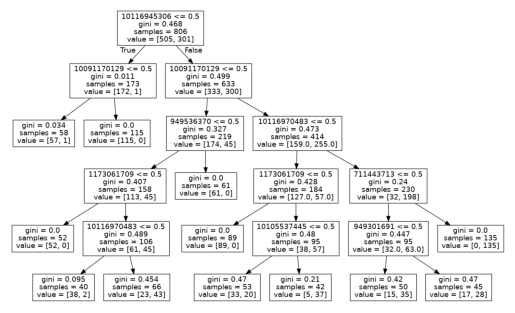

In [397]:
ca.show_tree()

In [398]:
result_limits['high_CART'] = ca

In [399]:
### Run CART on samp_high_results
for i in range(len(samp_high_results)):
    slr = high_results.iloc[samp_high_results[i]][0].to_numpy() > resultsDesc.loc['75%'][0]
    ca = CART.CART(high_inputs.iloc[samp_high_results[i]], slr)
    ca.build_tree()
    print(ca.stats_to_dataframe())
    print(ca.boxes_to_dataframe())
    result_limits['samp_high_CART_' + str(i)] = ca

        coverage  density  res dim  mass
box 1   0.000000      0.0        1  0.18
box 2   0.000000      0.0        4  0.08
box 3   0.022727      0.2        5  0.05
box 4   0.000000      0.0        5  0.06
box 5   0.000000      0.0        4  0.05
box 6   0.181818      0.8        4  0.10
box 7   0.000000      0.0        4  0.06
box 8   0.045455      0.4        5  0.05
box 9   0.068182      0.6        5  0.05
box 10  0.477273      1.0        4  0.21
box 11  0.136364      1.0        5  0.06
box 12  0.068182      0.6        5  0.05
            box 1      box 2      box 3      box 4      box 5       ... box 8  \
              min  max   min  max   min  max   min  max   min  max  ...   min   
10116945306   0.0  0.5   0.5  1.0   0.5  1.0   0.5  1.0   0.5  1.0  ...   0.5   
10105537445   0.0  1.0   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0  ...   0.0   
1173061709    0.0  1.0   0.0  0.5   0.5  1.0   0.5  1.0   0.0  0.5  ...   0.5   
711443713     0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0 

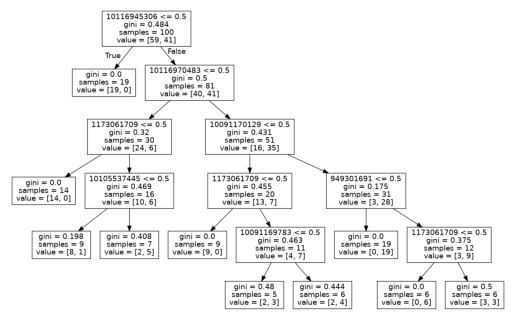

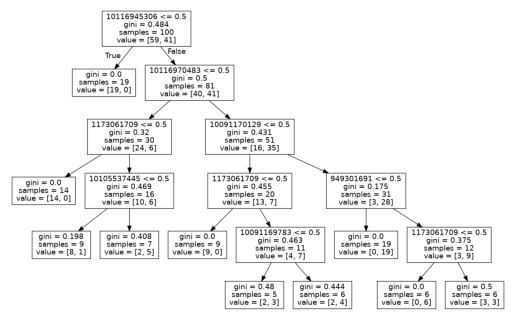

In [400]:
ca.show_tree()

In [401]:
print(len(result_limits))

18


In [402]:
result_limits.keys()

dict_keys(['high_limits', 'low_limits', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3', 'high_kmeans', 'low_kmeans', 'low_CART', 'high_CART', 'samp_high_CART_0', 'samp_high_CART_1', 'samp_high_CART_2', 'samp_high_CART_3'])

In [403]:
### create function go get feature names from prim limits
def get_feature_names(limits):
    feature_names = []
    for key in list(limits.index):        
        ### convert key to integer        
        feature_names.append(int(key))
    return feature_names

def get_kmeans_features(df, kmeans, cluster):
    return df.columns[kmeans.labels_ == cluster]


In [404]:
### Get the features from PRIM
print(get_feature_names(result_limits['high_limits']))

### Get the features from the kmeans
print(list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 2]))

### get the feature names from the cart
print(get_feature_names(result_limits['high_CART'].boxes_to_dataframe()['box 2']))

### print the number of clusters in result_limits['high_kmeans']
print(len(pd.Series(result_limits['high_kmeans'].labels_).value_counts()))
### print the number of boxes in result_limits['high_CART']
print(len(result_limits['high_CART'].boxes_to_dataframe()))


[10116970483, 10116945306, 10091170129, 711443713]
['1173061709', '10116970483']
[10116945306, 10091170129, 10105537445, 949536370, 711443713, 10116970483, 1173061709, 949301691]
6
8


In [405]:
highClusters = {}
highClusters['prim'] = get_feature_names(result_limits['high_limits'])
highClusters['prim1'] = get_feature_names(result_limits['samp_high_results_0'])
highClusters['prim2'] = get_feature_names(result_limits['samp_high_results_1'])
highClusters['prim3'] = get_feature_names(result_limits['samp_high_results_2'])
highClusters['prim4'] = get_feature_names(result_limits['samp_high_results_3'])
highClusters['kmeans'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 0])
highClusters['kmeans1'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 1])
highClusters['kmeans2'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 2])
highClusters['kmeans3'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 3])
highClusters['cart'] = get_feature_names(result_limits['high_CART'].boxes_to_dataframe()['box 2'])
highClusters['cart1'] = get_feature_names(result_limits['samp_high_CART_0'].boxes_to_dataframe()['box 2'])
highClusters['cart2'] = get_feature_names(result_limits['samp_high_CART_1'].boxes_to_dataframe()['box 2'])
highClusters['cart3'] = get_feature_names(result_limits['samp_high_CART_2'].boxes_to_dataframe()['box 2'])
highClusters['cart4'] = get_feature_names(result_limits['samp_high_CART_3'].boxes_to_dataframe()['box 2'])


lowClusters = {}
lowClusters['prim'] = get_feature_names(result_limits['low_limits'])
lowClusters['prim1'] = get_feature_names(result_limits['samp_low_results_0'])
lowClusters['prim2'] = get_feature_names(result_limits['samp_low_results_1'])
lowClusters['prim3'] = get_feature_names(result_limits['samp_low_results_2'])
lowClusters['prim4'] = get_feature_names(result_limits['samp_low_results_3'])
lowClusters['kmeans'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 0])
lowClusters['kmeans1'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 1])
lowClusters['kmeans2'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 2])
lowClusters['kmeans3'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 3])
lowClusters['cart'] = get_feature_names(result_limits['low_CART'].boxes_to_dataframe()['box 2'])
lowClusters['cart1'] = get_feature_names(result_limits['samp_low_CART_0'].boxes_to_dataframe()['box 2'])
lowClusters['cart2'] = get_feature_names(result_limits['samp_low_CART_1'].boxes_to_dataframe()['box 2'])
lowClusters['cart3'] = get_feature_names(result_limits['samp_low_CART_2'].boxes_to_dataframe()['box 2'])
lowClusters['cart4'] = get_feature_names(result_limits['samp_low_CART_3'].boxes_to_dataframe()['box 2'])

ValueError: can only convert an array of size 1 to a Python scalar

In [406]:
highClusters['prim1']

[10116970483, 10091170129, 10116945306, 10105537445]

In [407]:
highClusters['cart']

[10116945306,
 10091170129,
 10105537445,
 949536370,
 711443713,
 10116970483,
 1173061709,
 949301691]

### Find similar features from the 3 clusters

In [408]:
### for each highClusters find the intersection of the features
hc_count = {}
for hc in highClusters.keys():
    print(hc)
    for hc2 in highClusters.keys():
        if hc != hc2:            
            print("\t",hc2)
            intersect = set(highClusters[hc]).intersection(set(highClusters[hc2]))
            print("\t", intersect)
            for i in intersect:
                if i in hc_count.keys():
                    hc_count[i] += 1
                else:
                    hc_count[i] = 1
                  
print(" ------------------------------------ ")

lc_count = {}
### for each lowClusters find the intersection of the features
for lc in lowClusters.keys():
    print(lc)
    for lc2 in lowClusters.keys():
        if lc != lc2:            
            print("\t", lc2)
            intersect = set(lowClusters[lc]).intersection(set(lowClusters[lc2]))
            print("\t", intersect)
            for i in intersect:
                if i in lc_count.keys():
                    lc_count[i] += 1
                else:
                    lc_count[i] = 1


prim
	 prim1
	 {10091170129, 10116945306, 10116970483}
	 prim2
	 {10091170129, 10116945306, 10116970483}
	 prim3
	 {10091170129, 10116945306, 10116970483, 711443713}
	 prim4
	 {10091170129, 10116945306, 10116970483}
	 kmeans
	 set()
	 kmeans1
	 set()
	 kmeans2
	 set()
	 kmeans3
	 set()
	 cart
	 {10091170129, 10116945306, 10116970483, 711443713}
	 cart1
	 {10091170129, 10116945306, 10116970483, 711443713}
	 cart2
	 {10091170129, 10116945306, 10116970483, 711443713}
	 cart3
	 {10091170129, 10116945306, 10116970483, 711443713}
	 cart4
	 {10091170129, 10116945306, 10116970483}
prim1
	 prim
	 {10091170129, 10116945306, 10116970483}
	 prim2
	 {10091170129, 10116945306, 10116970483}
	 prim3
	 {10091170129, 10116945306, 10116970483}
	 prim4
	 {10091170129, 10116945306, 10116970483}
	 kmeans
	 set()
	 kmeans1
	 set()
	 kmeans2
	 set()
	 kmeans3
	 set()
	 cart
	 {10091170129, 10116945306, 10116970483, 10105537445}
	 cart1
	 {10091170129, 10116945306, 10116970483, 10105537445}
	 cart2
	 {10091170

In [409]:
lc_count

{}

In [410]:
hc_count

{10091170129: 90,
 10116945306: 90,
 10116970483: 90,
 711443713: 30,
 10105537445: 20,
 10112051514: 6,
 949301691: 6,
 1173061709: 20,
 10091169783: 2}

In [411]:
### sort hc_count by values and then print the top 10 keys
sorted_hc = sorted(hc_count.items(), key=lambda x: x[1], reverse=True)
### print just the key for the top 10 sorted_hc
sorted_keys = []
for i in range(10):
    sorted_keys.append(str(sorted_hc[i][0]))
    #print(sorted_hc[i][0])
sorted_keys

IndexError: list index out of range

In [412]:
highClusters.keys()

dict_keys(['prim', 'prim1', 'prim2', 'prim3', 'prim4', 'kmeans', 'kmeans1', 'kmeans2', 'kmeans3', 'cart', 'cart1', 'cart2', 'cart3', 'cart4'])

In [413]:
from mlxtend.frequent_patterns import apriori, association_rules

In [414]:
example_data = {
    'A': [1, 1, 1, 0],
    'B': [1, 0, 1, 1],
    'C': [1, 1, 0, 1]
}
example_df = pd.DataFrame(example_data)

In [415]:
example_df

A  B  C
0  1  1  1
1  1  0  1
2  1  1  0
3  0  1  1

In [416]:
df[:100][df.columns[:10]]


10105537445  1173061709  949301691  10091170129  10116945306  10112051514  \
0             1           1          1            0            0            0   
1             0           0          1            1            1            1   
2             1           1          1            0            1            1   
3             0           1          1            0            1            0   
4             1           0          1            0            0            1   
..          ...         ...        ...          ...          ...          ...   
95            1           0          0            1            0            1   
96            1           0          1            0            0            1   
97            0           0          0            0            1            1   
98            0           1          0            0            1            0   
99            0           1          1            1            1            0   

    10116970483  949536370  10091169783  711443713  
0             0          0            0          0  
1             0          0            0          0  
2             1          1            1          0  
3             1          0            1          0  
4             0          0            1          0  
..          ...        ...          ...        ...  
95            1          1            1          0  
96            1          0            1          1  
97            1          0            0          1  
98            0          0            1          0  
99            1          1            0          1  

[100 rows x 10 columns]

In [417]:
# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.048, use_colnames=True)

/home/pfoytik/anaconda3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [418]:
print("Frequent Itemsets:\n", frequent_itemsets)

Frequent Itemsets:
      support                                           itemsets
0     0.4995                                      (10105537445)
1     0.5000                                       (1173061709)
2     0.5000                                        (949301691)
3     0.5000                                      (10091170129)
4     0.5000                                      (10116945306)
..       ...                                                ...
380   0.0660  (10112051514, 949536370, 10091169783, 10116970...
381   0.0585   (10112051514, 949536370, 10116970483, 711443713)
382   0.0590  (10112051514, 10091169783, 711443713, 10116970...
383   0.0620   (10112051514, 949536370, 10091169783, 711443713)
384   0.0655   (949536370, 10091169783, 711443713, 10116970483)

[385 rows x 2 columns]


In [419]:
### write hc_count to json
import json

### HC/LC count is the count of intersection features between cluster methods
### high/low Clusters is the cluster features for each method and samples
### ['prim', 'prim1', 'prim2', 'prim3', 'prim4', 'kmeans', 'kmeans1', 'kmeans2', 'kmeans3', 'cart', 'cart1', 'cart2', 'cart3', 'cart4']
with open('hc_count.json', 'w') as f:
    json.dump(hc_count, f)

with open('lc_count.json', 'w') as f:
    json.dump(lc_count, f)

### write high_clusters to json
with open('high_clusters.json', 'w') as f:
    json.dump(highClusters, f)

### write low_clusters to json
with open('low_clusters.json', 'w') as f:
    json.dump(lowClusters, f)


In [198]:
### read in hc_count.json
with open('hc_count.json', 'r') as f:
    hc_count_json = json.load(f)

### read in lc_count.json
with open('lc_count.json', 'r') as f:
    lc_count_json = json.load(f)

### read in high_clusters.json
with open('high_clusters.json', 'r') as f:
    high_clusters_json = json.load(f)

### read in low_clusters.json
with open('low_clusters.json', 'r') as f:
    low_clusters_json = json.load(f)

# PCA of Data

In [104]:
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import numpy as np

#corr_matrix = high_inputs.iloc[samp_high_results[0]].corr()
corr_matrix = np.corrcoef(high_inputs.iloc[samp_high_results[0]].T)


#pca = PCA(n_components=4)
#pca_data = pca.fit_transform(X)


### plot pca_data
#plt.scatter(pca_data[:,0], pca_data[:,1])
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.show()




In [105]:
pca = PCA(n_components=50)  # Retain the top 50 components
reduced_data = pca.fit_transform(high_inputs.iloc[samp_high_results[0]].T) 

In [106]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=20, batch_size=100)
kmeans.fit(high_inputs.iloc[samp_high_results[0]].T)  # Cluster features directly

MiniBatchKMeans(batch_size=100, n_clusters=20)

In [107]:
from sklearn.random_projection import GaussianRandomProjection

rp = GaussianRandomProjection(n_components=100)
reduced_features = rp.fit_transform(high_inputs.iloc[samp_high_results[0]].T) 

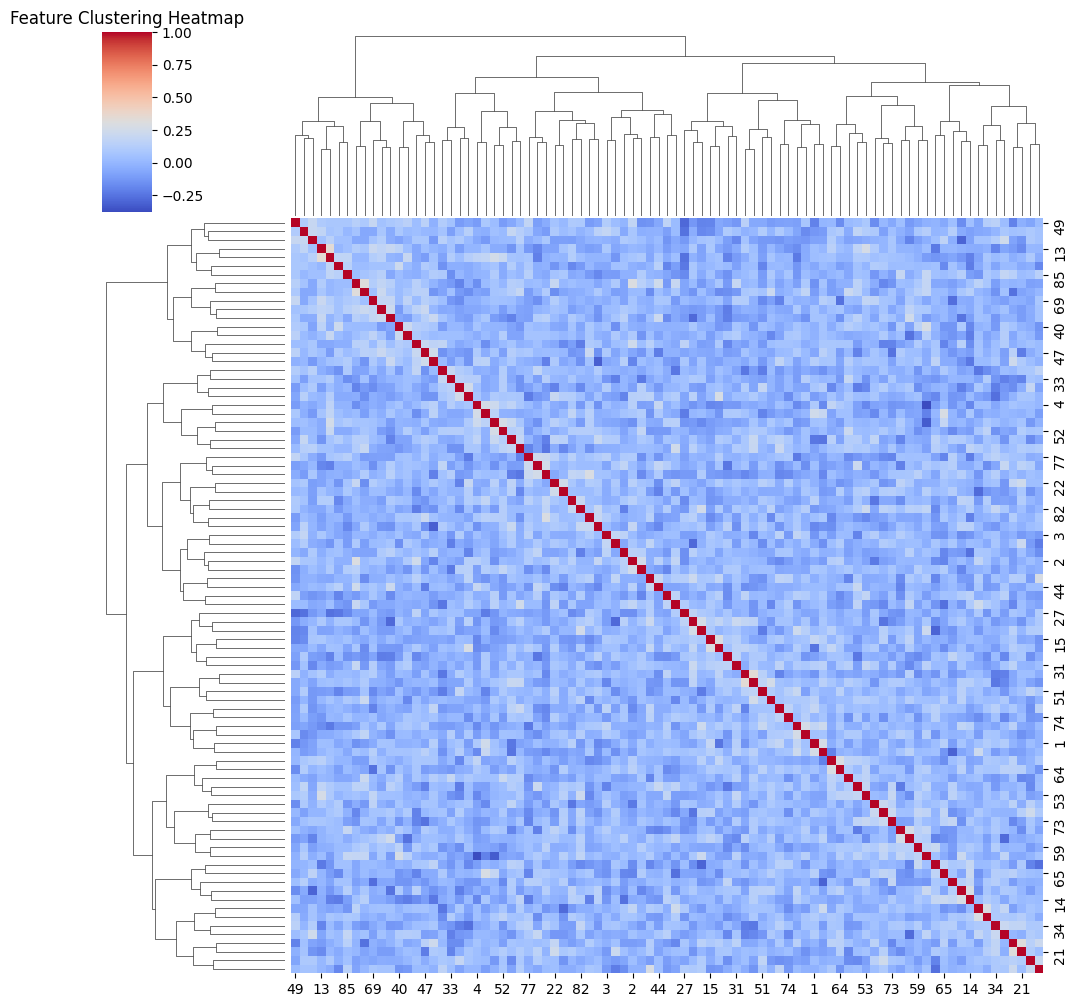

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `corr_matrix` is your correlation matrix and `cluster_labels` are assigned
sns.clustermap(
    corr_matrix, 
    metric="euclidean", 
    method="ward", 
    cmap="coolwarm", 
    figsize=(10, 10),
    row_cluster=True, 
    col_cluster=True
)
plt.title("Feature Clustering Heatmap")
plt.show()


In [109]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
linked = linkage(corr_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=high_results.columns, orientation='right', leaf_font_size=8)
plt.title("Feature Clustering Dendrogram")
plt.show()

ValueError: Dimensions of Z and labels must be consistent.

<Figure size 1000x700 with 0 Axes>

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

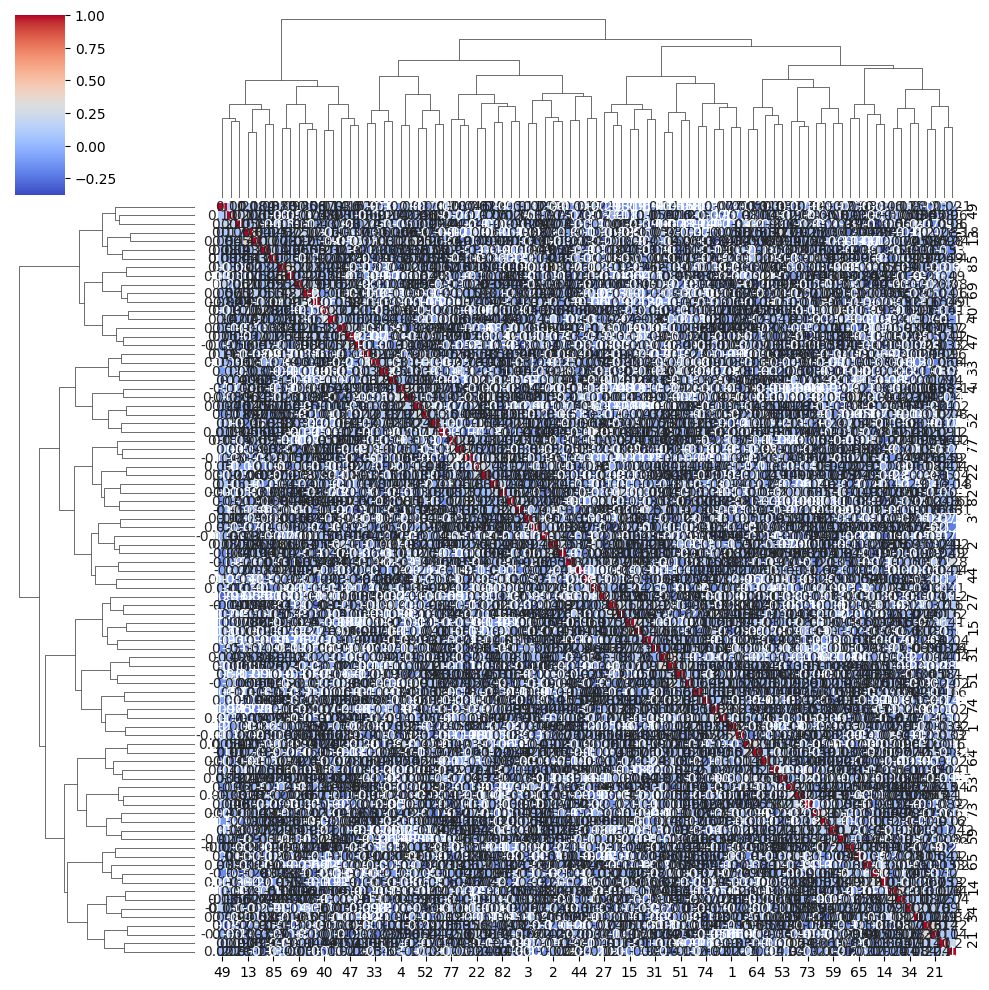

In [110]:
feature_names = high_inputs.iloc[samp_high_results[0]].columns
X = high_inputs.iloc[samp_high_results[0]].to_numpy()

sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', metric='euclidean', method='ward')
distances = 1 - corr_matrix
clustering = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average')
cluster_labels = clustering.fit_predict(distances)

In [137]:
kmeans = KMeans(n_clusters=3, random_state=21)
cluster_labels = kmeans.fit_predict(pca_data)

original_data = pd.DataFrame(X, columns=feature_names)
original_data['Cluster'] = cluster_labels

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=feature_names)
print("PCA Loadings (Feature Contributions to PCs):")
print(loadings)

# Analyze original feature means by cluster
print("\nFeature Means by Cluster:")
print(original_data.groupby('Cluster').mean())

PCA Loadings (Feature Contributions to PCs):
           PC1       PC2       PC3       PC4
2     0.018517 -0.000552 -0.005853 -0.002170
4     0.015184  0.000136 -0.023232 -0.006237
5     0.017556  0.008186 -0.020537  0.011255
6     0.013526  0.015565  0.005246 -0.027834
8     0.015074  0.000787 -0.005955 -0.014284
...        ...       ...       ...       ...
8911  0.006044 -0.002998  0.005637  0.001623
8914  0.005029 -0.000487 -0.003976  0.000407
8956  0.006026 -0.005356  0.005100  0.000464
8964  0.007253 -0.011518  0.006645  0.001589
8976  0.006845 -0.012466  0.005410 -0.002746

[4499 rows x 4 columns]

Feature Means by Cluster:
             2         4         5         6         8         9         10    \
Cluster                                                                         
0        0.000000  0.016194  0.000000  0.008097  0.000000  0.008097  0.004049   
1        0.051695  0.046693  0.048916  0.044469  0.042802  0.051695  0.056698   
2        0.004016  0.000000  0.004016  

In [139]:
len(original_data)

2295

### Measure dependence of the features in the clusters

In [111]:
print(len(experiments), len(outcomes))

1526 1526


In [112]:
### print descriptive statistics of outcomes
print(df_results.describe())

                 0
count  1526.000000
mean      4.799530
std       1.363112
min       3.673417
25%       3.825190
50%       4.263578
75%       5.288782
max      10.639947


In [113]:
###print df_results that are greater than 4.4
print(df_results[df_results[0] > 4.4])

             0
1     5.906310
2     5.527798
4     5.441164
7     5.263983
8     4.491252
...        ...
1514  8.004577
1516  5.085063
1518  4.454118
1519  8.000135
1520  4.880901

[674 rows x 1 columns]


In [114]:
### cluster df_results where the value is greater than 4.4
kmeans = KMeans(n_clusters=4, random_state=21).fit(df_results[df_results[0] > 4.4])

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())




2    363
0    197
3     64
1     50
Name: count, dtype: int64


In [115]:
### print the results for cluster 3
df_cluster = df_results[df_results[0] > 4.4]
print(df_cluster[kmeans.labels_ == 3])



             0
10    7.995863
87    6.976111
91    7.878779
126   8.056444
127   8.043555
...        ...
1400  8.039769
1476  8.085242
1480  8.255099
1514  8.004577
1519  8.000135

[64 rows x 1 columns]


In [116]:
### get the index values of df_cluster[kmeans.labels_ == 3]
idx = df_cluster[kmeans.labels_ == 3].index

### get the rows of experiments based on idx
print(experiments.iloc[idx])

      340786  329056  331077  343426  333272  329043  335360  329174  334899  \
10         0       1       0       1       1       1       1       1       0   
87         0       1       0       0       0       1       1       0       0   
91         0       0       0       1       0       1       0       1       0   
126        1       0       0       0       1       0       0       1       0   
127        1       0       0       1       1       0       0       0       1   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1400       0       0       1       1       1       1       1       1       0   
1476       0       1       1       1       0       1       0       1       0   
1480       0       0       0       0       0       0       1       1       1   
1514       1       0       1       1       1       0       1       0       0   
1519       1       0       0       1       1       1       0       0       0   

      329644  ...  328156  344407  3301

In [120]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

mi_matrix = np.zeros(((len(df.columns), len(df.columns))))
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        mi_matrix[i, j] = mutual_info_regression(df.iloc[:, i].values.reshape(-1, 1), df.iloc[:, j].values)

mi_matrix

/tmp/ipykernel_31255/1305173201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] = mutual_info_regression(df.iloc[:, i].values.reshape(-1, 1), df.iloc[:, j].values)
/tmp/ipykernel_31255/1305173201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] = mutual_info_regression(df.iloc[:, i].values.reshape(-1, 1), df.iloc[:, j].values)
/tmp/ipykernel_31255/1305173201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] =

array([[0.67501375, 0.00591585, 0.0049019 , ..., 0.        , 0.        ,
        0.00322141],
       [0.        , 0.69588328, 0.        , ..., 0.02947781, 0.01876154,
        0.        ],
       [0.01752244, 0.01445998, 0.67634669, ..., 0.00290934, 0.        ,
        0.02452282],
       ...,
       [0.        , 0.01392021, 0.        , ..., 0.67437758, 0.        ,
        0.        ],
       [0.00836913, 0.03697351, 0.        , ..., 0.01373855, 0.6846067 ,
        0.        ],
       [0.        , 0.        , 0.02469615, ..., 0.        , 0.0201611 ,
        0.73359352]])

In [121]:
print(len(mi_scores))
mi_scores[2]


NameError: name 'mi_scores' is not defined

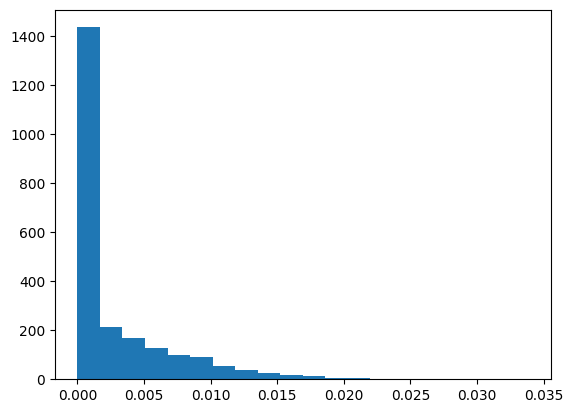

In [ ]:
### Print histogram of mi_scores
plt.hist(mi_scores, bins=20)
plt.show()